In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision import models
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import cv2 
import pydicom
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms

from torch import nn
# from efficientnet_pytorch import EfficientNet
# from efficientnet_pytorch.utils import MemoryEfficientSwish
import warnings

import random
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
import pydicom
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())
import sys

from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from datetime import datetime, timedelta
from time import time
import torch.nn.functional as F
import copy

In [2]:
!pip install resnet_pytorch
!pip install efficientnet_pytorch

In [3]:
package_path = '../input/resnet-pytorch/ResNet-PyTorch/ResNet-PyTorch-master'
sys.path.append(package_path)
package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)

In [4]:
package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)

In [5]:
from efficientnet_pytorch import EfficientNet
from resnet_pytorch import ResNet 

In [6]:
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark =True
    
seed_everything(42)

In [13]:
class Config:
    def __init__(self):
        self.FOLDS = 2
        self.EPOCHS = 5
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
        self.TRAIN_BS = 32
        self.VALID_BS = 128
        self.model_type = '18'
        self.loss_fn = nn.L1Loss()
        
config = Config()

In [14]:
path = Path('/kaggle/input/osic-pulmonary-fibrosis-progression/')
path.ls()

[PosixPath('/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv'),
 PosixPath('/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv'),
 PosixPath('/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv'),
 PosixPath('/kaggle/input/osic-pulmonary-fibrosis-progression/test'),
 PosixPath('/kaggle/input/osic-pulmonary-fibrosis-progression/train')]

In [15]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [16]:
train_df = train_df.drop(np.nonzero(np.array(train_df['Patient'] == 'ID00011637202177653955184',dtype=float))[0], axis=0).reset_index(drop=True)
train_df = train_df.drop(np.nonzero(np.array(train_df['Patient'] == 'ID00052637202186188008618',dtype=float))[0], axis=0).reset_index(drop=True)

In [17]:
def get_tab(df):
    vector = [(df.Weeks.values[0] - 30 )/30]
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [18]:
TAB = {}
TARGET = {}
Person = []

for i, p in tqdm(enumerate(train_df.Patient.unique())):
    sub = train_df.loc[train_df.Patient == p]
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    TARGET[p] = a
    TAB[p] = get_tab(sub)
    Person.append(p)

Person = np.array(Person)

174it [00:00, 940.55it/s]


In [19]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [20]:
class Dataset:
    def __init__(self, path, df, tabular, targets, mode , folder = 'train' ):
        self.df = df
        self.tabular = tabular
        self.targets = targets
        self.folder = folder
        self.mode = mode
        self.path = path
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.loc[idx,:]
        pid = row['Patient']
        # Path to record
        record = self.path/self.folder/pid
        # select image id
        try: 
            
            img_id =  np.random.choice(len(record.ls()))
            
            img = get_img(record.ls()[img_id])
            img = self.transform(img)
            tab = torch.from_numpy(self.tabular[pid]).float()
            if self.mode == 'train':
                target = torch.tensor(self.targets[pid])
                return (img,tab), target
            else:
                return (img,tab)
        except Exception as e:
            print(e)
            print(pid, img_id)

In [21]:
def collate_fn(b):
    xs, ys = zip(*b)
    imgs, tabs = zip(*xs)
    return (torch.stack(imgs).float(),torch.stack(tabs).float()),torch.stack(ys).float()

In [37]:
class OSIC_Model(nn.Module):
    def __init__(self,eff_name='18'):
        super().__init__()
        self.input = nn.Conv2d(1,3,kernel_size=3,padding=1,stride=2)
        self.bn = nn.BatchNorm2d(3)
        self.model = ResNet.from_pretrained(f'resnet{eff_name}')
        self.model.fc = nn.Linear(512, 500, bias=True)
        self.meta = nn.Sequential(nn.Linear(4, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500,250),
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.output = nn.Linear(500+250, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x,tab):
        x = self.relu(self.bn(self.input(x)))
        x = self.model(x)
        tab = self.meta(tab)
        x = torch.cat([x, tab],dim=1)
        return self.output(x)

In [38]:
from sklearn.model_selection import KFold

def get_split_idxs(n_folds=5):
    kv = KFold(n_splits=n_folds)
    splits = []
    for i,(train_idx, valid_idx) in enumerate(kv.split(Person)):
        splits.append((train_idx, valid_idx))
        
    return splits

In [39]:
splits = get_split_idxs(n_folds=config.FOLDS)

In [48]:
def train_loop(model, dl, opt, sched, device, loss_fn):
    model.train()
    for X,y in dl:
        imgs = X[0].to(device)
        tabs = X[1].to(device)
        y = y.to(device)
        outputs = model(imgs, tabs)
        loss = loss_fn(outputs.squeeze(), y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if sched is not None:
            sched.step()
            

def eval_loop(model, dl, device, loss_fn):
    model.eval()
    final_outputs = []
    final_loss = []
    with torch.no_grad():
        for X,y in dl:
            imgs = X[0].to(device)
            tabs = X[1].to(device)
            y=y.to(device)

            outputs = model(imgs, tabs)
            loss = loss_fn(outputs.squeeze(), y)

            final_outputs.extend(outputs.detach().cpu().numpy().tolist())
            final_loss.append(loss.detach().cpu().numpy())
        
    return final_outputs, final_loss

In [49]:
from functools import partial

def apply_mod(m,f):
    f(m)
    for l in m.children(): apply_mod(l,f)

def set_grad(m,b):
    if isinstance(m, (nn.Linear, nn.BatchNorm2d)): return 
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b)

In [50]:
models = {}
for i in range(config.FOLDS):
    models[i] = OSIC_Model(config.model_type)

Loaded pretrained weights for resnet18.
Loaded pretrained weights for resnet18.


In [51]:
for k,v in models.items():
    apply_mod(v.model, partial(set_grad, b=False))

In [52]:
train = train_df.loc[train_df['Patient'].isin(Person[:21])].reset_index(drop=True)
train_ds = Dataset(path, train, TAB, TARGET, mode='train')
train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=config.TRAIN_BS,
    shuffle=True,
    collate_fn=collate_fn        
)

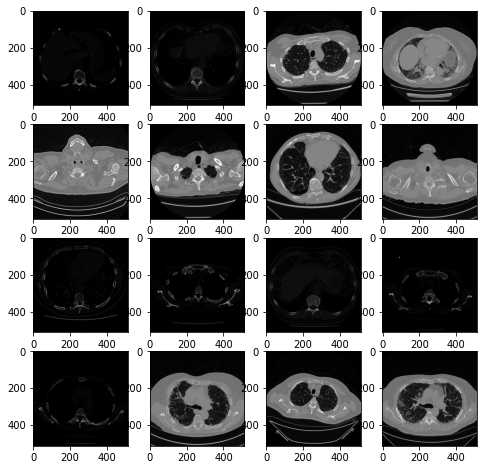

In [53]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
i=1
for X,y in train_dl:
    pass
j=0
for i in range(1, columns*rows +1):
    img = np.array(X[0][j].permute(1,2,0))
    img = cv2.cvtColor(img ,cv2.COLOR_GRAY2RGB)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    j += 1
plt.show()

In [54]:
history = []

In [55]:
for i, (train_idx, valid_idx) in enumerate(splits):
    print(f"===================Fold : {i} ================")

    train = train_df.loc[train_df['Patient'].isin(Person[train_idx])].reset_index(drop=True)
    valid = train_df.loc[train_df['Patient'].isin(Person[valid_idx])].reset_index(drop=True)


    train_ds = Dataset(path, train, TAB, TARGET, mode= 'train')
    train_dl = torch.utils.data.DataLoader(
        dataset=train_ds,
        batch_size=config.TRAIN_BS,
        shuffle=True,
        collate_fn=collate_fn        
    )

    valid_ds = Dataset(path, valid, TAB, TARGET, mode='train')
    valid_dl = torch.utils.data.DataLoader(
        dataset=valid_ds,
        batch_size=config.VALID_BS,
        shuffle=False,
        collate_fn=collate_fn
    )

    model = models[i]
    model.to(config.DEVICE)
    lr=1e-3
    momentum = 0.9
    
    num_steps = len(train_dl)
    optimizer = Adam(model.parameters(), lr=lr,weight_decay=0.1)
    scheduler = OneCycleLR(optimizer, 
                           max_lr=lr,
                           epochs=config.EPOCHS,
                           steps_per_epoch=num_steps
                           )
    sched = ReduceLROnPlateau(optimizer,
                              verbose=True,
                              factor=0.1)
    losses = []
    for epoch in range(config.EPOCHS):
        print(f"=================EPOCHS {epoch+1}================")
        train_loop(model, train_dl, optimizer, scheduler, config.DEVICE,config.loss_fn)
        metrics = eval_loop(model, valid_dl,config.DEVICE,config.loss_fn)
        total_loss = np.array(metrics[1]).mean()
        losses.append(total_loss)
        print("Loss ::\t", total_loss)
        sched.step(total_loss)

===================Fold : 0 ================
=================EPOCHS 1================
Loss ::	 4.5802875
=================EPOCHS 2================
Loss ::	 4.442917
=================EPOCHS 3================
Loss ::	 4.520874
=================EPOCHS 4================
Loss ::	 4.451022
=================EPOCHS 5================
Loss ::	 4.242398
===================Fold : 1 ================
=================EPOCHS 1================
Loss ::	 3.7720623
=================EPOCHS 2================
Loss ::	 4.0098696
=================EPOCHS 3================
Loss ::	 3.9106922
=================EPOCHS 4================
Loss ::	 4.1602855
=================EPOCHS 5================
Loss ::	 3.9719312


In [56]:
for k, m in models.items():
    torch.save(m.state_dict(), f'fold_{k}.pth')

In [57]:
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')


In [58]:
test_data= []
for i in range(len(test_df)):
    for j in range(-12, 134):
        test_data.append([test_df['Patient'][i],j,test_df['Age'][i],test_df['Sex'][i],test_df['SmokingStatus'][i], test_df['FVC'][i],test_df['Percent'][i
        ],str(test_df['Patient'][i])+'_'+str(j)])

test_data = pd.DataFrame(test_data, columns=['Patient','Weeks','Age','Sex','SmokingStatus','FVC','Percent','Patient_Week'])

In [59]:
TAB_test = {}

Person_test = []

for i, p in tqdm(enumerate(test_data.Patient.unique())):
    sub = test_data.loc[test_data.Patient == p]

    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T

    TAB_test[p] = get_tab(sub)
    Person_test.append(p)

Person_test = np.array(Person_test)

5it [00:00, 964.47it/s]


In [60]:
def collate_fn_test(b):
    imgs, tabs = zip(*b)
    return (torch.stack(imgs).float(),torch.stack(tabs).float())

In [61]:
TARGET = {}
test = test_data
test_ds = Dataset(path, test_data, TAB_test,TARGET, mode= 'test')
test_dl = torch.utils.data.DataLoader(
    dataset=test_ds,
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn_test        
)

In [62]:
avg_predictions= np.zeros((730,1))

for i in range(len(models)):
    
    predictions = []
    model = models[i]
    model = model.to(config.DEVICE)
    model.load_state_dict(torch.load('./fold_' +str(i)+'.pth'))
    model.eval()
    with torch.no_grad():
        for X in test_dl:
            imgs = X[0].to(config.DEVICE)
            tabs = X[1].to(config.DEVICE)

            pred = model(imgs, tabs)

            predictions.extend(pred.detach().cpu().numpy().tolist())
    avg_predictions += predictions

In [63]:
predictions = avg_predictions / len(models)

In [64]:
fvc = []
conf = []
for i in range(len(test_data)):
    p =test_data['Patient'][i]
    B_test = predictions[i][0] * test_df.Weeks.values[test_df.Patient == p][0]
    fvc.append(predictions[i][0] * test_data['Weeks'][i] + test_data['FVC'][i] - B_test)
    conf.append(test_data['Percent'][i] + abs(predictions[i][0]) * abs(test_df.Weeks.values[test_df.Patient == p][0] - test_data['Weeks'][i]))

In [65]:
submission = test_data[['Patient_Week']]

In [66]:
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [67]:
subm ={}
for i in range(len(submission)):
    subm[submission['Patient_Week'][i]]=[float(fvc[i]),float(conf[i])]

In [68]:
sub['FVC'] = sub['FVC'].astype(float)
sub['Confidence'] = sub['Confidence'].astype(float)
for i in range(len(sub)):
    id = sub['Patient_Week'][i]
    sub['FVC'][i]= float(subm[id][0])
    sub['Confidence'][i] = float(subm[id][1])

In [69]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3099.209031,149.395886
1,ID00421637202311550012437_-12,2851.132844,194.178135
2,ID00422637202311677017371_-12,1993.997283,140.669776
3,ID00423637202312137826377_-12,3404.612347,189.871250
4,ID00426637202313170790466_-12,2970.589990,117.414958


In [70]:
sub.to_csv('submission_img.csv', index=False)